# Genereative Adversarial Networks

The main goal of **Generative Adversarial Network** (GAN) is to generate images that are similar (but not identical) to training dataset.

GAN consists of two neural networks that are trained against each other:

 * **Generator** takes a random vector, and should generate an image from it
 * **Discriminator** is a networks that should distinguish between original image (from training dataset), and the one generated by the generator.

<img src="./images/gan_architecture.png" width="70%"/>

In [274]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [275]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 1.0
lr = 2e-4
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999
batch_size = 256
epochs = 100
plot_every = 10

## Generator

The role of a generator is to take a random vector of some size (it is similar to latent vector in autoencoders) and generate the target image. It is very similar to the generative side of autoencoder.

In our example, we will use linear neural networks and MNIST dataset.

In [276]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)
        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))
        generated = self.tanh(self.linear4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

A few tricks used in generator:
* Instead of ReLU, we use **LeakyReLU**, i.e. a ReLU which is not exactly 0 for negative $x$, but rather another linear function with very small slope.
* We use **BatchNorm1D** in order to stabilize training
* The activation function on last layer is **Tanh**, so the output is in the range [-1,1].

## Discriminator

Discriminator is a classical image classification network. In our first example, we will also use linear classifier.

In [277]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        classififed = self.sigmoid(self.linear3(hidden2))
        return classififed

## Loading dataset

We will use MNIST dataset.

In [278]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [279]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
])

In [280]:
train_dataset, test_dataset = mnist(train_size, transform)

In [281]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

## Network training

On each step of the training, we have **two** phases:

* **Generator** training. We generate some random vectors **noise** (training happens in minibatches, so we use 100 vectors at a time), generate **true labels** (vector with shape (bs, 1) with 1.0 values), calculate generator loss between output from **frozen** discriminator with noise as input and true labels.

* **Discriminator** training. We calculate discriminator loss from **two** parts, **first** part is loss between output from discriminator with noise as input and **fake labels** (vector with shape (bs, 1) with 0.0 values), **second** part is loss between output from discriminator with real images as input and true labels (vector with shape (bs, 1) with 1.0 values). **Result loss** is (first_part_loss + second_part_loss) / 2.

In [282]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [283]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            
            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [284]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/100 [00:00<?, ?it/s]

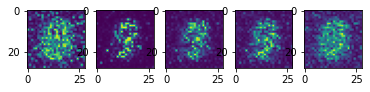

 10%|█         | 10/100 [01:32<13:49,  9.21s/it, generator loss:=1.04, discriminator loss:=0.547]

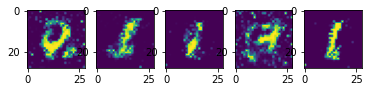

 20%|██        | 20/100 [03:05<12:18,  9.23s/it, generator loss:=0.935, discriminator loss:=0.596]

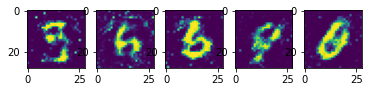

 30%|███       | 30/100 [04:38<10:47,  9.24s/it, generator loss:=0.9, discriminator loss:=0.617]  

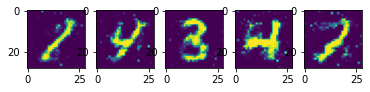

 40%|████      | 40/100 [06:11<09:16,  9.28s/it, generator loss:=0.851, discriminator loss:=0.634]

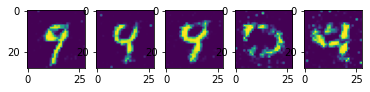

 50%|█████     | 50/100 [07:45<07:49,  9.38s/it, generator loss:=0.839, discriminator loss:=0.638]

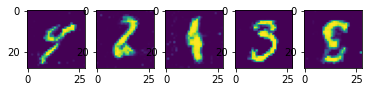

 60%|██████    | 60/100 [09:19<06:21,  9.54s/it, generator loss:=0.836, discriminator loss:=0.637]

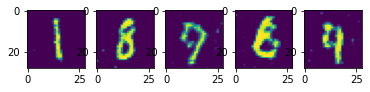

 70%|███████   | 70/100 [10:52<04:38,  9.27s/it, generator loss:=0.844, discriminator loss:=0.636]

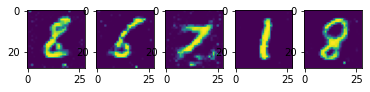

 80%|████████  | 80/100 [12:27<03:05,  9.30s/it, generator loss:=0.853, discriminator loss:=0.634]

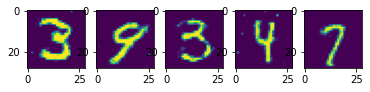

 90%|█████████ | 90/100 [13:59<01:31,  9.19s/it, generator loss:=0.854, discriminator loss:=0.633]

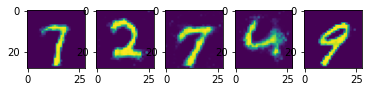

 99%|█████████▉| 99/100 [15:23<00:09,  9.29s/it, generator loss:=0.866, discriminator loss:=0.629]

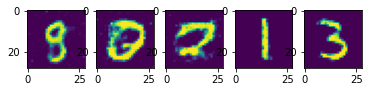

100%|██████████| 100/100 [15:32<00:00,  9.33s/it, generator loss:=0.865, discriminator loss:=0.629]


In [285]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

## DCGAN

**Deep Convolutional GAN** is pretty obvious idea of using convolutional layers for generator and discriminator. The main difference here is using **Conv2DTranspose** layer in the generator.

<img src="images/dcgan_generator.png" width="60%"/>

> Image from [this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [286]:
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))
        generated = self.tanh(self.conv4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

In [287]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.leaky_relu(self.conv1(input))
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))
        classified = self.sigmoid(self.conv4(hidden3)).view(input.shape[0], -1)
        return classified

Weights initialization from [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [288]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [289]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [290]:
train_dataset, test_dataset = mnist(train_size, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [291]:
generator = DCGenerator().to(device)
generator.apply(weights_init)
discriminator = DCDiscriminator().to(device)
discriminator.apply(weights_init)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [292]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [293]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]
    
    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            
            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

  0%|          | 0/50 [00:00<?, ?it/s]

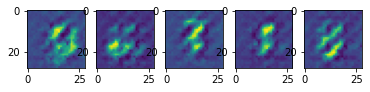

 10%|█         | 5/50 [00:53<08:03, 10.74s/it, generator loss:=2.38, discriminator loss:=0.256]

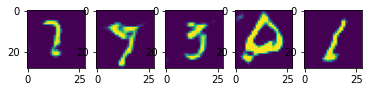

 20%|██        | 10/50 [01:47<07:03, 10.58s/it, generator loss:=2.12, discriminator loss:=0.254]

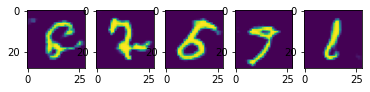

 30%|███       | 15/50 [02:40<06:12, 10.66s/it, generator loss:=2.2, discriminator loss:=0.255] 

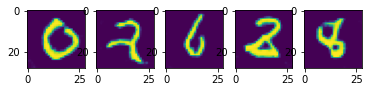

 40%|████      | 20/50 [03:33<05:17, 10.57s/it, generator loss:=2.21, discriminator loss:=0.266]

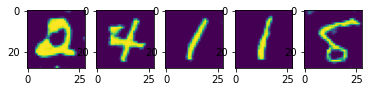

 50%|█████     | 25/50 [04:27<04:24, 10.60s/it, generator loss:=2.34, discriminator loss:=0.229]

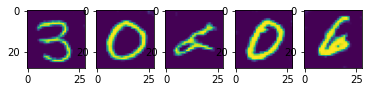

 60%|██████    | 30/50 [05:20<03:32, 10.65s/it, generator loss:=2.42, discriminator loss:=0.225]

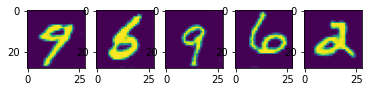

 70%|███████   | 35/50 [06:13<02:39, 10.60s/it, generator loss:=2.55, discriminator loss:=0.216]

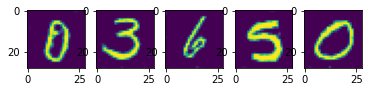

 80%|████████  | 40/50 [07:07<01:46, 10.62s/it, generator loss:=2.62, discriminator loss:=0.207]

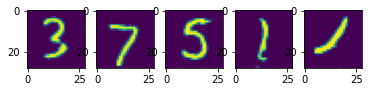

 90%|█████████ | 45/50 [08:00<00:52, 10.55s/it, generator loss:=2.8, discriminator loss:=0.178] 

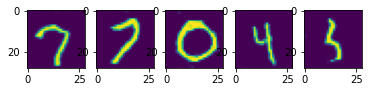

 98%|█████████▊| 49/50 [08:43<00:10, 10.65s/it, generator loss:=2.77, discriminator loss:=0.2]  

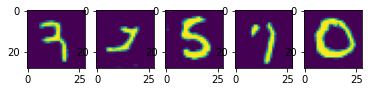

100%|██████████| 50/50 [08:54<00:00, 10.68s/it, generator loss:=2.79, discriminator loss:=0.184]


In [294]:
train_dcgan(dataloaders, models, optimizers, loss_fn, epochs // 2, plot_every // 2, device)

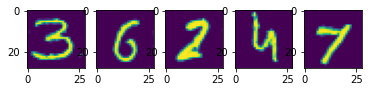

In [304]:
generator.eval()
dcplotn(5, generator, device)

> **Task**: Try generating more complex color images with DCGAN - for example, take one class from [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) dataset.

## Training on Paintings

One of the good candidates for GAN training are paintings created by human artists.

![](https://soshnikov.com/images/artartificial/Flo1.jpg)

(Photo from [Art of Artificial](https://soshnikov.com/museum/art-artificial/) collection)

## References

* [GAN arxiv](https://arxiv.org/abs/1406.2661)
* [DCGAN arxiv](https://arxiv.org/abs/1511.06434)
* [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)